# Document Clustering and Topic Modeling

In this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualized the results and identify their latent topics/ structures.

# Part 0: Setup Google Drive Environment

## Part 0.1 Fetch Files From Google Drive

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
file = drive.CreateFile({'id':'146hytT_mgkHDVRaDARdL_5-J6i-_XfP_'})
file.GetContentFile('metadata.csv')

# Part 1: Import Packages

In [4]:
import gc
import re
import os
import json
import heapq
import pickle
import string
import random
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from unicodedata import normalize

import numba
from numba import prange
from pandarallel import pandarallel
from multiprocessing import Pool, cpu_count

import nltk 
import spacy
from nltk.stem.snowball import SnowballStemmer 
nltk.download('punkt') 
nltk.download('stopwords') 
from nltk.corpus import stopwords
from gensim.models import CoherenceModel, TfidfModel
from gensim.models import LdaModel, LdaMulticore
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from pyjarowinkler import distance

import numpy as np 
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import silhouette_score 

import matplotlib.pyplot as plt


%matplotlib inline
output_notebook()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Set figure size for matplotlib
plt.rcParams["figure.figsize"] = (10, 10)
pd.options.display.max_colwidth=160

# Part 2: Load Data

In [7]:
class DataHandler(object):
  '''
  Class that is used to load all the data from the CORD-19 dataset
  '''
  def __init__(self, filename):
    self.filename = filename
  
  def read_metadata(self):
    return pd.read_csv(self.filename, sep=',', error_bad_lines=False)

In [8]:
filename = 'metadata.csv'
data_handler = DataHandler(filename)
df_meta = data_handler.read_metadata()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [9]:
df_meta.dropna(subset=['title'], inplace=True)
df_meta.dropna(subset=['abstract'], inplace=True)
df_meta = df_meta[df_meta['publish_time'] > '2020-00-00']
df_meta.reset_index(inplace=True, drop=True)
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163223 entries, 0 to 163222
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          163223 non-null  object 
 1   sha               100266 non-null  object 
 2   source_x          163223 non-null  object 
 3   title             163223 non-null  object 
 4   doi               137736 non-null  object 
 5   pmcid             90676 non-null   object 
 6   pubmed_id         110333 non-null  object 
 7   license           163223 non-null  object 
 8   abstract          163223 non-null  object 
 9   publish_time      163223 non-null  object 
 10  authors           162340 non-null  object 
 11  journal           144205 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  19693 non-null   object 
 14  arxiv_id          6270 non-null    object 
 15  pdf_json_files    100266 non-null  object 
 16  pmc_json_files    77

In [10]:
df_meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,f9tg6xsg,44449ad1cca160ce491d7624f8ae1028f3570c45,PMC,Dexmedetomidine improved renal function in patients with severe sepsis: an exploratory analysis of a randomized controlled trial,10.1186/s40560-019-0415-z,PMC6939335,31908779,cc-by,BACKGROUND: Dexmedetomidine has been reported to improve organ dysfunction in critically ill patients. In a recent randomized controlled trial (Dexmedetomid...,2020-01-02,"Nakashima, Tsuyoshi; Miyamoto, Kyohei; Shima, Nozomu; Kato, Seiya; Kawazoe, Yu; Ohta, Yoshinori; Morimoto, Takeshi; Yamamura, Hitoshi",J Intensive Care,NaN,NaN,NaN,document_parses/pdf_json/44449ad1cca160ce491d7624f8ae1028f3570c45.json,document_parses/pmc_json/PMC6939335.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6939335/,NaN
1,f73c639r,def41c08c3cb1b3752bcff34d3aed7f8486e1c86,PMC,Aortic volume determines global end-diastolic volume measured by transpulmonary thermodilution,10.1186/s40635-019-0284-8,PMC6940405,31897796,cc-by,BACKGROUND: Global end-diastolic volume (GEDV) measured by transpulmonary thermodilution is regarded as indicator of cardiac preload. A bolus of cold saline...,2020-01-02,"Akohov, Aleksej; Barner, Christoph; Grimmer, Steffen; Francis, Roland CE; Wolf, Stefan",Intensive Care Med Exp,NaN,NaN,NaN,document_parses/pdf_json/def41c08c3cb1b3752bcff34d3aed7f8486e1c86.json,document_parses/pmc_json/PMC6940405.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6940405/,NaN
2,1qgpa45q,f5ae3f66face323615df39d838e056ab5fcc98df,PMC,Whole genome sequencing and phylogenetic analysis of human metapneumovirus strains from Kenya and Zambia,10.1186/s12864-019-6400-z,PMC6941262,31898474,cc-by,BACKGROUND: Human metapneumovirus (HMPV) is an important cause of acute respiratory illness in young children. Whole genome sequencing enables better identi...,2020-01-02,"Kamau, Everlyn; Oketch, John W.; de Laurent, Zaydah R.; Phan, My V. T.; Agoti, Charles N.; Nokes, D. James; Cotten, Matthew",BMC Genomics,NaN,NaN,NaN,document_parses/pdf_json/f5ae3f66face323615df39d838e056ab5fcc98df.json,document_parses/pmc_json/PMC6941262.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941262/,NaN
3,g34f5w6b,5be75ae4e7f8c892abd8dc396b9dbd035772c84a,PMC,European intensive care physicians’ experience of infections due to antibiotic-resistant bacteria,10.1186/s13756-019-0662-8,PMC6941296,31908772,cc-by,"BACKGROUND: Antimicrobial resistance (AMR) compromises the treatment of patients with serious infections in intensive care units (ICUs), and intensive care ...",2020-01-02,"Lepape, Alain; Jean, Astrid; De Waele, Jan; Friggeri, Arnaud; Savey, Anne; Vanhems, Philippe; Gustin, Marie Paule; Monnet, Dominique L.; Garnacho-Montero, J...",Antimicrob Resist Infect Control,NaN,NaN,NaN,document_parses/pdf_json/5be75ae4e7f8c892abd8dc396b9dbd035772c84a.json,document_parses/pmc_json/PMC6941296.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941296/,NaN
4,d1pd09zj,1cee4a0d0e823379ec34a462a04561bf4cd736a2,PMC,Synthetic carbohydrate-based vaccines: challenges and opportunities,10.1186/s12929-019-0591-0,PMC6941340,31900143,cc-by,Glycoconjugate vaccines based on bacterial capsular polysaccharides (CPS) have been extremely successful in preventing bacterial infections. The glycan anti...,2020-01-03,"Mettu, Ravinder; Chen, Chiang-Yun; Wu, Chung-Yi",J Biomed Sci,NaN,NaN,NaN,document_parses/pdf_json/1cee4a0d0e823379ec34a462a04561bf4cd736a2.json,document_parses/pmc_json/PMC6941340.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941340/,NaN


In [11]:
columns_to_keep = [
            'cord_uid',
            'sha',
            'title',
            'abstract',
            'publish_time',
            'authors',
            'pdf_json_files',
            'url'
]
df_meta_filtered = df_meta[columns_to_keep]
df_meta_filtered.head()

,cord_uid,sha,title,abstract,publish_time,authors,pdf_json_files,url
0,f9tg6xsg,44449ad1cca160ce491d7624f8ae1028f3570c45,Dexmedetomidine improved renal function in patients with severe sepsis: an exploratory analysis of a randomized controlled trial,BACKGROUND: Dexmedetomidine has been reported to improve organ dysfunction in critically ill patients. In a recent randomized controlled trial (Dexmedetomid...,2020-01-02,"Nakashima, Tsuyoshi; Miyamoto, Kyohei; Shima, Nozomu; Kato, Seiya; Kawazoe, Yu; Ohta, Yoshinori; Morimoto, Takeshi; Yamamura, Hitoshi",document_parses/pdf_json/44449ad1cca160ce491d7624f8ae1028f3570c45.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6939335/
1,f73c639r,def41c08c3cb1b3752bcff34d3aed7f8486e1c86,Aortic volume determines global end-diastolic volume measured by transpulmonary thermodilution,BACKGROUND: Global end-diastolic volume (GEDV) measured by transpulmonary thermodilution is regarded as indicator of cardiac preload. A bolus of cold saline...,2020-01-02,"Akohov, Aleksej; Barner, Christoph; Grimmer, Steffen; Francis, Roland CE; Wolf, Stefan",document_parses/pdf_json/def41c08c3cb1b3752bcff34d3aed7f8486e1c86.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6940405/
2,1qgpa45q,f5ae3f66face323615df39d838e056ab5fcc98df,Whole genome sequencing and phylogenetic analysis of human metapneumovirus strains from Kenya and Zambia,BACKGROUND: Human metapneumovirus (HMPV) is an important cause of acute respiratory illness in young children. Whole genome sequencing enables better identi...,2020-01-02,"Kamau, Everlyn; Oketch, John W.; de Laurent, Zaydah R.; Phan, My V. T.; Agoti, Charles N.; Nokes, D. James; Cotten, Matthew",document_parses/pdf_json/f5ae3f66face323615df39d838e056ab5fcc98df.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941262/
3,g34f5w6b,5be75ae4e7f8c892abd8dc396b9dbd035772c84a,European intensive care physicians’ experience of infections due to antibiotic-resistant bacteria,"BACKGROUND: Antimicrobial resistance (AMR) compromises the treatment of patients with serious infections in intensive care units (ICUs), and intensive care ...",2020-01-02,"Lepape, Alain; Jean, Astrid; De Waele, Jan; Friggeri, Arnaud; Savey, Anne; Vanhems, Philippe; Gustin, Marie Paule; Monnet, Dominique L.; Garnacho-Montero, J...",document_parses/pdf_json/5be75ae4e7f8c892abd8dc396b9dbd035772c84a.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941296/
4,d1pd09zj,1cee4a0d0e823379ec34a462a04561bf4cd736a2,Synthetic carbohydrate-based vaccines: challenges and opportunities,Glycoconjugate vaccines based on bacterial capsular polysaccharides (CPS) have been extremely successful in preventing bacterial infections. The glycan anti...,2020-01-03,"Mettu, Ravinder; Chen, Chiang-Yun; Wu, Chung-Yi",document_parses/pdf_json/1cee4a0d0e823379ec34a462a04561bf4cd736a2.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6941340/


In [12]:
data_title = df_meta_filtered.loc[:999,'title'].tolist()
data_abstract = df_meta_filtered.loc[:999,'abstract'].tolist()
data_merged = []
for i in range(len(data_title)):
  data_merged.append('Title: ' + data_title[i] + ' Abstract: ' + data_abstract[i])
print(len(data_merged))
df_data_merged = pd.DataFrame(data_merged, columns=['title_abstract'])
df_data_merged.drop_duplicates(subset='title_abstract')
df_data_merged.reset_index(drop=True, inplace=True)

1000


# Part 3: Data Preprocessing

In [13]:
class Preprocessor(object):
  def __init__(self, stopwords, stemmer):
    self.stopwords = stopwords
    self.stemmer = stemmer
  
  # tokenization and stemming
  def tokenization_and_stemming(self, text):
    tokens = []

    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

  def preprocess(self, text):
        """
        Main function to preprocess the text
        """
        lang = self.detect_language(text)
            
        if lang in ["en", "fr", "es", "it", "de", "pt"]:
            nlp = self.nlp_list[lang]
        else:
            nlp = self.nlp_list[self.default_language]
            
        # Delete some punctuation before preprocessing BUT not all of it because some can be involved in n-grams (e.g. "-")
        text=re.sub(r'[!"#$%&\'()*+,./:;<=>?@\[\\\]^_`{|}~]',r' ',text) 
        
        # Apply spacy to the text
        doc = nlp(text)
        # Lemmatization, remotion of noise (stopwords, digit, puntuaction and singol characters)
        tokens = [
            token.lemma_ for token in doc if
            token.lemma_ != '-PRON-'
            and not token.is_punct
            and not token.is_digit
            and not token.like_num
            and not token.like_url
            and not token.like_email
            and len(token.lemma_) >= self.min_token_len and len(token.text) >= self.min_token_len
            and token.lemma_.lower() not in self.stop_list_all and token.text.lower() not in self.stop_list_all
        ]
        
        # Recreation of the text
        text = " ".join(tokens)

        # Remove accents, normalize to ascii
        if self.force_ascii:
            text = normalize('NFD', text).encode('ascii', 'ignore').decode('UTF-8')
        
        if self.force_deaccent:
            text = deaccent(text)
    
        # Remove double spaces
        text=re.sub(r'\s+',r' ',text)
        
        # Set as lowercase
        text = text.lower().strip()

In [14]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english') #stopwords.append("n't")
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") #html <br>
stopwords.append("COVID")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

stemmer = SnowballStemmer("english")
preprocessor = Preprocessor(stopwords, stemmer)
tokens = preprocessor.tokenization_and_stemming(data_merged[0])
print(tokens)

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
['titl', 'dexmedetomidin', 'improv', 'renal', 'function', 'patient', 'sever', 'sepsi', 'exploratori', 'analysi', 'random', 'control', 'trial', 'abstract', 'background', 'dexmedetomidin', 'report', 'improv', 'organ', 'dysfunct', 'critic', 'ill', 'patient', 'recent', 'random', 'control', 'trial', 'dexmedetomidin', 'sepsi', 'intens', 'care', 'unit', 'icu', 'random', 'evolut', 'desir', 'demonstr', 'dexmedetomidin', 'associ', 'reduc', 'mortal', 'risk', 'among', 'patient', 'sever', 'sepsi', 'perform', 'exploratori', 'examin', 'mechan', 'under', 'improv', 'surviv', 'patient', 'sedat', 'dexmedetomidin', 'method', 'desir', 'trial', 'compar', 'sedat', 'strategi', 'without', 'dexmedetomidin', 'among', 'mechan', 'ventil', 'adult', 'patient', 'sepsi', 'across', 'eight', 'icus', 'japan', 'present', 'studi', 'includ', 'patient', 'acut', 'physiolog', 'chronic', 'health', 'evalu', 'ii

# Part 4: TF-IDF

TF: Term Frequency

IDF: Inverse Document Frequency

In [15]:
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=preprocessor.tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data_merged) #fit the vectorizer to synopses

print("For merged title and abstract: ")
print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " documents and " + str(tfidf_matrix.shape[1]) + " terms.")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.



For merged title and abstract: 
In total, there are 1000 documents and 1000 terms.


In [16]:
print(type(tfidf_matrix))
print(tfidf_matrix.toarray())
print(type(tfidf_matrix.toarray()))
print(tfidf_matrix.todense())
print(type(tfidf_matrix.todense()))

<class 'scipy.sparse.csr.csr_matrix'>
[[0.         0.         0.         ... 0.03612245 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.08546487 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.03612245 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.08546487 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
<class 'numpy.matrix'>


In [17]:
tf_selected_words = tfidf_model.get_feature_names()
print(tf_selected_words)
print(len(tf_selected_words))

['abdomin', 'abil', 'abnorm', 'absenc', 'abund', 'access', 'accord', 'account', 'accumul', 'accur', 'accuraci', 'achiev', 'acid', 'acquir', 'act', 'action', 'activ', 'acut', 'ad', 'adapt', 'addit', 'address', 'adequ', 'adher', 'adjust', 'adjuv', 'administ', 'administr', 'admiss', 'admit', 'adolesc', 'adopt', 'adult', 'advanc', 'advantag', 'advers', 'aeruginosa', 'affect', 'africa', 'age', 'agent', 'aim', 'airway', 'algorithm', 'allow', 'alon', 'alter', 'altern', 'amino', 'amplif', 'analys', 'analysi', 'analyz', 'anim', 'annual', 'antibiot', 'antibodi', 'antigen', 'antimicrobi', 'antivir', 'aortic', 'apach', 'appear', 'appli', 'applic', 'approach', 'appropri', 'approxim', 'ard', 'area', 'art', 'arteri', 'articl', 'aspect', 'assay', 'assess', 'assist', 'associ', 'attent', 'attenu', 'aureus', 'author', 'avail', 'averag', 'avoid', 'b', 'background', 'bacteri', 'bacteria', 'balanc', 'barrier', 'base', 'baselin', 'baumannii', 'becom', 'behavior', 'benefit', 'best', 'better', 'bias', 'bind', 

# Part 5: K-means clustering

## 5.0.1 Implement K-means method and evaluate k using Elbow Method

Text(0, 0.5, 'Sum of squared distance')

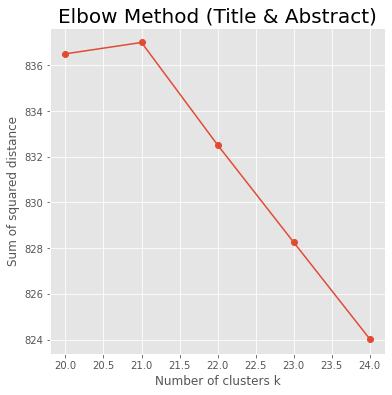

In [18]:
# k-means clustering
from sklearn.cluster import KMeans

kmeans_model_list_1 = []
num_clusters_list = list(range(20,25))
inertia_list = []

# number of clusters
for num_clusters in num_clusters_list:
  km = KMeans(n_clusters=num_clusters)
  kmeans_model_list_1.append(km)
  km.fit(tfidf_matrix)
  inertia_list.append(km.inertia_)

# plot see against k
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
plt.plot(num_clusters_list, inertia_list, '-o')
plt.title('Elbow Method (Title & Abstract)',fontsize = 20)
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sum of squared distance')

## 5.0.2 Implement K-means method and evaluate k using Sihouette Analysis

Text(0, 0.5, 'Sihouette Value')

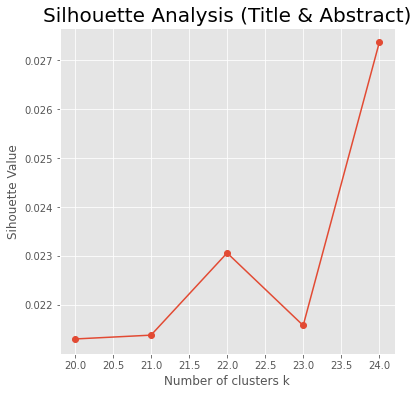

In [19]:
num_clusters_list = list(range(20,25))
sil = []
kmax = 10
kmeans_model_list_2 = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in num_clusters_list:
  km = KMeans(n_clusters = k).fit(tfidf_matrix)
  kmeans_model_list_2.append(km)
  labels = km.labels_
  sil.append(silhouette_score(tfidf_matrix, labels, metric = 'euclidean'))

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
plt.plot(num_clusters_list, sil, '-o')
plt.title('Silhouette Analysis (Title & Abstract)',fontsize = 20)
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sihouette Value')


## 5.1 Analyze K-means Result

In [20]:
km = kmeans_model_list_1[2]
# create DataFrame films from all of the input files.
clusters = km.labels_.tolist()
df_title_abstract = pd.DataFrame(data_merged, columns=['titleabstract'])
doc = { 'TitleAbstract': df_title_abstract[:1000].titleabstract, 'cluster': clusters}
frame = pd.DataFrame(doc, columns = ['TitleAbstract', 'cluster'])
print(frame.head(10))
print(frame.shape)

                                                                                                                                                     TitleAbstract  cluster
0  Title: Dexmedetomidine improved renal function in patients with severe sepsis: an exploratory analysis of a randomized controlled trial Abstract: BACKGROUND...        7
1  Title: Aortic volume determines global end-diastolic volume measured by transpulmonary thermodilution Abstract: BACKGROUND: Global end-diastolic volume (GED...        9
2  Title: Whole genome sequencing and phylogenetic analysis of human metapneumovirus strains from Kenya and Zambia Abstract: BACKGROUND: Human metapneumovirus ...        3
3  Title: European intensive care physicians’ experience of infections due to antibiotic-resistant bacteria Abstract: BACKGROUND: Antimicrobial resistance (AMR...        8
4  Title: Synthetic carbohydrate-based vaccines: challenges and opportunities Abstract: Glycoconjugate vaccines based on bacterial capsular 

In [21]:
print("Number of title & abstract included in each cluster")
frame['cluster'].value_counts().to_frame()

Number of title & abstract included in each cluster


,cluster
6,139
12,73
18,68
13,65
2,55
11,55
10,47
14,47
16,46
9,45


In [22]:
print(km.cluster_centers_)
print(km.cluster_centers_.shape)

[[0.         0.01139602 0.00243196 ... 0.01203567 0.00308309 0.00314086]
 [0.0023899  0.         0.00313659 ... 0.00729803 0.         0.        ]
 [0.         0.00184341 0.         ... 0.00921617 0.00540068 0.02099449]
 ...
 [0.         0.00344882 0.01335271 ... 0.04140077 0.0084829  0.        ]
 [0.         0.         0.00381325 ... 0.00115058 0.00732684 0.        ]
 [0.00542513 0.00216619 0.02986031 ... 0.01314816 0.00760991 0.        ]]
(22, 1000)


In [23]:
print ("<Document clustering result by K-means>")

#km_title.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

# print(km.n_clusters)
num_clusters = km.n_clusters
# print(num_clusters)
Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster = frame[frame.cluster==i].TitleAbstract.tolist()
    print ("Cluster " + str(i) + " title & abstract (" + str(len(cluster)) + " title & abstract): ")
    print (", ".join(cluster))
    print ()

<Document clustering result by K-means>
Cluster 0 words:diseas,treatment,patient,transplant,inhibitor,trial,
Cluster 0 title & abstract (37 title & abstract): 
Title: Extracorporeal membrane oxygenation as a bridge to lung transplantation: analysis of Korean organ transplantation registry (KOTRY) data Abstract: BACKGROUND: The use of extracorporeal membrane oxygenation (ECMO) as a bridge to lung transplantation has greatly increased. However, data regarding the clinical outcomes of this approach are lacking. The objective of this multicenter prospective observational cohort study was to evaluate lung transplantation outcomes in Korean Organ Transplantation Registry (KOTRY) patients for whom ECMO was used as a bridge to transplantation. METHODS: Between March 2015 and December 2017, a total of 112 patients received lung transplantation and were registered in the KOTRY, which is a prospective, multicenter cohort registry. The entire cohort was divided into two groups: the control group (

## 5.2 Find related articles based on risk factors key words

In [24]:
QUERY = ["fluid", "pneumonia", "gene", "lung", "bacteri", "rna", "antibodi", "liver", "women"]
# Step 1: process query by tokenization and stemming
processed_query = [preprocessor.tokenization_and_stemming(QUERY[i]) for i in range(len(QUERY))]
# Step 2: find which cluster(s) has/have the key words
order_centroids = km.cluster_centers_.argsort()[:,::-1]
num_clusters = km.n_clusters
Cluster_keywords_summary = {}
cluster_summary = {}
output = []
for i in range(num_clusters):
  Cluster_keywords_summary[i] = []
  for ind in order_centroids[i, :20]:
    Cluster_keywords_summary[i].append(tf_selected_words[ind])
    cluter = frame[frame.cluster==i].TitleAbstract.tolist()
    cluster_summary[i] = frame[frame.cluster==i].TitleAbstract.tolist()
for j in range(len(QUERY)):
  for i in range(len(Cluster_keywords_summary)):
    if processed_query[j][0] in Cluster_keywords_summary[i]:
      output.append(cluster_summary[i][:10])
      break
# print(len(output))
for j in range(len(output)):
  print("Query: ", processed_query[j][0])
  for i, paper in enumerate(output[j]):
    print("Recommendation.", i, ": ", paper)

Query:  fluid
Recommendation. 0 :  Title: Whole genome sequencing and phylogenetic analysis of human metapneumovirus strains from Kenya and Zambia Abstract: BACKGROUND: Human metapneumovirus (HMPV) is an important cause of acute respiratory illness in young children. Whole genome sequencing enables better identification of transmission events and outbreaks, which is not always possible with sub-genomic sequences. RESULTS: We report a 2-reaction amplicon-based next generation sequencing method to determine the complete genome sequences of five HMPV strains, representing three subgroups (A2, B1 and B2), directly from clinical samples. In addition to reporting five novel HMPV genomes from Africa we examined genetic diversity and sequence patterns of publicly available HMPV genomes. We found that the overall nucleotide sequence identity was 71.3 and 80% for HMPV group A and B, respectively, the diversity between HMPV groups was greater at amino acid level for SH and G surface protein genes

## Part 6: LDA

In [25]:
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser

coherence_score = []
model_list = []

start = 8
end = 40
step = 2

docs_tokens = []
for ele in data_merged:
  stem = preprocessor.tokenization_and_stemming(ele)
  docs_tokens.append(stem)

bigram_mod = Phraser(Phrases(docs_tokens, min_count=10, threshold=10))
docs_bigram_tokens = [bigram_mod[doc] for doc in docs_tokens]

id2word = Dictionary(docs_bigram_tokens)
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

corpus = [id2word.doc2bow(doc) for doc in docs_bigram_tokens]
for num_topics in range(start, end, step):
  model = LdaModel(
      corpus=corpus,
      num_topics=num_topics,
      id2word=id2word,
      update_every=1,
      eval_every=100,
      random_state=100,
      chunksize=2000,
      passes=4,
      iterations=100,
      per_word_topics=True
  )

  model_list.append(model)
  coherencemodel=CoherenceModel(model=model, texts=docs_bigram_tokens, dictionary=id2word,coherence='c_v')
  coherence_score.append(coherencemodel.get_coherence())

Text(0, 0.5, 'Coherence Score')

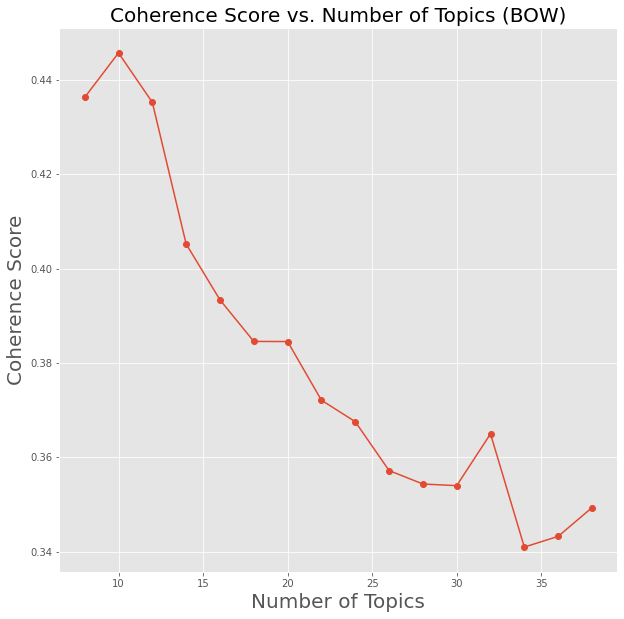

In [26]:
plt.style.use('ggplot')
plt.plot(range(start, end, step), coherence_score,'-o')
plt.title('Coherence Score vs. Number of Topics (BOW)',fontsize = 20)
plt.xlabel('Number of Topics',fontsize = 20)
plt.ylabel('Coherence Score', fontsize = 20)


Text(0.5, 1.0, 'Coherence Score vs. Number of Topics (TF-IDF)')

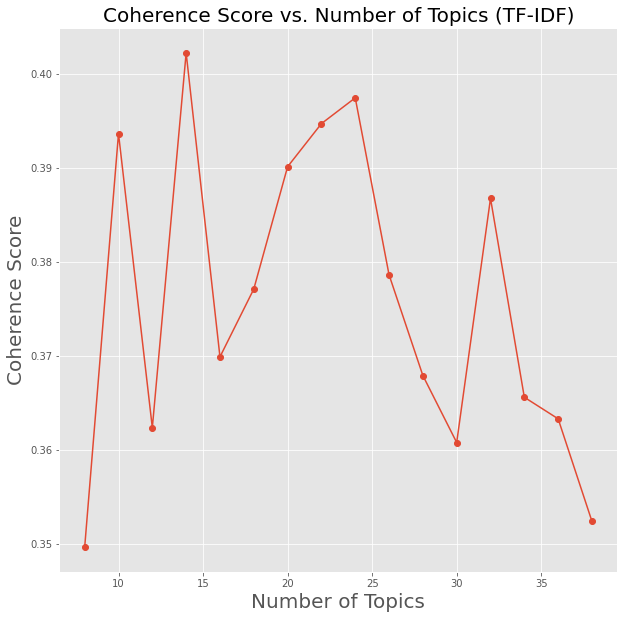

In [27]:
from gensim.models import TfidfModel
tfidf = TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

start = 8
end = 40
step = 2

coherence_score = []
model_list = []
for num_topics in range(start, end, step):
  model = LdaModel(
      corpus=tfidf_corpus,
      num_topics=num_topics,
      id2word=id2word,
      update_every=1,
      eval_every=100,
      random_state=100,
      chunksize=2000,
      passes=4,
      iterations=100,
      per_word_topics=True
  )

  model_list.append(model)
  coherencemodel=CoherenceModel(model=model, texts=docs_bigram_tokens, dictionary=id2word,coherence='c_v')
  coherence_score.append(coherencemodel.get_coherence())

plt.style.use('ggplot')
plt.plot(range(start, end, step), coherence_score,'-o')
plt.xlabel('Number of Topics',fontsize = 20)
plt.ylabel('Coherence Score',fontsize = 20)
plt.title('Coherence Score vs. Number of Topics (TF-IDF)',fontsize = 20)

In [28]:
lda_model = model_list[1]

In [ ]:
columns_name = []
pd_dict = {}

num_topic = lda_model.num_topics
for i in range(num_topic):
  columns_name.append(((f"Topic_{i+1}", "Word")))
  words, weight = zip(*lda_model.show_topic(i))
  pd_dict[f"topic{i+1}"] = list(words)

df = pd.DataFrame(pd_dict)
print(df)

      topic1     topic2   topic3  ...       topic8    topic9   topic10
0       wean    patient     cell  ...          hiv       act   patient
1       obes       mice     mice  ...        infus  knowledg       die
2      birth     infect    virus  ...          ard   protect   surgeri
3  influenza       week  inhibit  ...      patient   syndrom    mortal
4      genet     vaccin   vaccin  ...       cancer       pig      acut
5      speci  pneumonia  protect  ...            p     train      case
6    variant     plasma  express  ...  ard_patient    infect     sepsi
7     infant      manag    immun  ...         test    review    diseas
8    patient    protect   infect  ...         case      care    hospit
9    reactiv       wean  protein  ...         time  children  diagnosi

[10 rows x 10 columns]


In [ ]:
# Step 1: process query by tokenization and stemming
QUERY = ["disease", "infection", "women", "cancer", "lung", "liver", "antibodi", "protein", "chest"]
processed_query = [preprocessor.tokenization_and_stemming(QUERY[i]) for i in range(len(QUERY))]
# Step 2: find what words are in each topic
vocabulary = [id2word[i] for i in id2word.keys()]
topic_list = {}
for i, topic in enumerate(lda_model.get_topics().argsort(axis=1)[:,-15:][:,::-1],1):
  topic_list[i] = ' '.join(vocabulary[id] for id in topic)
  print('Topic {}: {}'.format(i, ' '.join([vocabulary[id] for id in topic])))
# Step 3: find which topic the query is in
idx_list = []
for i in range(len(QUERY)):
  for j in range(1, len(topic_list)+1):
    if processed_query[i][0] in topic_list[j]:
      idx_list.append(j)
      break
# Step 4: Find the dominant topic for each document
print("======test==========")
sent_topics_df = pd.DataFrame()
for i, row in enumerate(lda_model[corpus]):
  fow = sorted(row, key=lambda x: (x[1]), reverse=True)
  for j, (topic_num, prop_topic) in enumerate(row):
    if j == 0:
      wp = lda_model.show_topic(topic_num)
      topic_keywords = ', '.join([word for word, prop in wp])
      sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),round(prop_topic,4),topic_keywords]), ignore_index=True)
    else:
      break
sent_topics_df.colums = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
contents = pd.Series(data_merged)
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

df_dominant_topic = sent_topics_df.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Keywords', 'Text']

df_dominant_topic.head(10)

# Step 5: find top k documents in this topic
output = {}
for i in range(len(idx_list)):
  pd_temp = df_dominant_topic[df_dominant_topic.Dominant_Topic == 5.0]
  pd_out = pd_temp.sort_values(by=['Topic_Perc_Contribution'],ascending=False)
  pd_out = pd_out[:10]
  # break
  output[i] = []
  for j in range(len(pd_out)):
    output[i].append(pd_out[j:j+1].Text)

for j in range(len(output)):
  print("Query: ", processed_query[j][0])
  for i, paper in enumerate(output[j]):
    print("Recommendation.", i, ": ", paper)

Topic 1: wean obes birth influenza genet speci variant infant patient reactiv pain outcom decis influenza_vaccin neonat
Topic 2: patient mice infect week vaccin pneumonia plasma manag protect wean acut chest sever antibodi virus
Topic 3: cell mice virus inhibit vaccin protect express immun infect protein activ antigen receptor adjuv entri
Topic 4: vaccin protein infect cell strain activ isol virus diseas sequenc gene antibodi parasit antigen host
Topic 5: articl select intens_care patient vaccin ten http onlin liver review found avail inform virus viral
Topic 6: patient hospit p mortal group rate care ci pneumonia day influenza compar outcom associ children
Topic 7: peep patient ventil p trial extub ard lung rna day transplant failur cohort grade analysi
Topic 8: hiv infus ard patient cancer p ard_patient test case time diagnost clinic_trial oral assess women
Topic 9: act knowledg protect syndrom pig train infect review care children communiti field prevent articl swine
Topic 10: patie

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access

